In [6]:
from google.colab import drive
import os

drive.mount('/content/drive')

zip_file_name = "surface.zip"
drive_zip_path = f"/content/drive/MyDrive/{zip_file_name}"
colab_zip_path = f"/content/{zip_file_name}"
unzip_destination = "/content/neu-dataset"

print(f"Copying {zip_file_name} from Drive to Colab...")
!cp "{drive_zip_path}" "{colab_zip_path}"

print(f"Unzipping {zip_file_name}...")
# -q (quiet) -n (never overwrite, if you've run it before)
!unzip -q -n "{colab_zip_path}" -d "{unzip_destination}"

print("Unzipping complete.")
print("Your dataset is now ready in:", unzip_destination)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copying surface.zip from Drive to Colab...
Unzipping surface.zip...
Unzipping complete.
Your dataset is now ready in: /content/neu-dataset


In [7]:
import shutil
import glob
import xml.etree.ElementTree as ET

base_dir = "/content/neu-dataset"
train_img_dir = os.path.join(base_dir, "train_images")
train_anno_dir = os.path.join(base_dir, "train_annotations")
valid_img_dir = os.path.join(base_dir, "valid_images")
valid_anno_dir = os.path.join(base_dir, "valid_annotations")

new_base_dir = "/content/classification-dataset"
new_train_dir = os.path.join(new_base_dir, "train")
new_valid_dir = os.path.join(new_base_dir, "valid")

os.makedirs(new_train_dir, exist_ok=True)
os.makedirs(new_valid_dir, exist_ok=True)

def process_annotations(image_dir, anno_dir, dest_dir):
    xml_files = glob.glob(os.path.join(anno_dir, "*.xml"))
    print(f"Found {len(xml_files)} XML files in {anno_dir}")

    for xml_file in xml_files:
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()

            filename = root.find("filename").text
            source_image_path = os.path.join(image_dir, filename)

            obj = root.find("object")
            if obj is None:
                continue

            class_name = obj.find("name").text

            # --- Create the destination class folder ---
            class_dest_dir = os.path.join(dest_dir, class_name)
            os.makedirs(class_dest_dir, exist_ok=True)

            # --- Copy the image ---
            dest_image_path = os.path.join(class_dest_dir, filename)
            if not os.path.exists(dest_image_path):
                shutil.copy(source_image_path, dest_image_path)

        except Exception as e:
            print(f"Error processing {xml_file}: {e}")

# Run the conversion
print("Processing training data...")
process_annotations(train_img_dir, train_anno_dir, new_train_dir)

print("\nProcessing validation data...")
process_annotations(valid_img_dir, valid_anno_dir, new_valid_dir)

print("\n--- Data Reorganization Complete! ---")
print(f"Your new classification-ready dataset is at: {new_base_dir}")

Processing training data...
Found 1700 XML files in /content/neu-dataset/train_annotations
Error processing /content/neu-dataset/train_annotations/pitted_surface_137.xml: [Errno 2] No such file or directory: '/content/neu-dataset/train_images/pitted_surface_137'
Error processing /content/neu-dataset/train_annotations/pitted_surface_29.xml: [Errno 2] No such file or directory: '/content/neu-dataset/train_images/pitted_surface_29'
Error processing /content/neu-dataset/train_annotations/pitted_surface_120.xml: [Errno 2] No such file or directory: '/content/neu-dataset/train_images/pitted_surface_120'
Error processing /content/neu-dataset/train_annotations/pitted_surface_104.xml: [Errno 2] No such file or directory: '/content/neu-dataset/train_images/pitted_surface_104'
Error processing /content/neu-dataset/train_annotations/pitted_surface_101.xml: [Errno 2] No such file or directory: '/content/neu-dataset/train_images/pitted_surface_101'
Error processing /content/neu-dataset/train_annotat

Using device: cuda
Found 6 classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']

--- Phase 1: Training the Classifier Head ---
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]



Epoch 0/9
----------
train Loss: 1.0537 Acc: 0.7152
valid Loss: 0.9311 Acc: 0.8864

Epoch 1/9
----------
train Loss: 0.4969 Acc: 0.8940
valid Loss: 0.3319 Acc: 0.9318

Epoch 2/9
----------
train Loss: 0.3932 Acc: 0.9142
valid Loss: 0.2332 Acc: 0.9432

Epoch 3/9
----------
train Loss: 0.3177 Acc: 0.9226
valid Loss: 0.1986 Acc: 0.9432

Epoch 4/9
----------
train Loss: 0.2892 Acc: 0.9181
valid Loss: 0.1828 Acc: 0.9545

Epoch 5/9
----------
train Loss: 0.2524 Acc: 0.9278
valid Loss: 0.1593 Acc: 0.9659

Epoch 6/9
----------
train Loss: 0.2360 Acc: 0.9259
valid Loss: 0.1338 Acc: 0.9659

Epoch 7/9
----------
train Loss: 0.2364 Acc: 0.9356
valid Loss: 0.1373 Acc: 0.9659

Epoch 8/9
----------
train Loss: 0.2077 Acc: 0.9525
valid Loss: 0.1416 Acc: 0.9545

Epoch 9/9
----------
train Loss: 0.2086 Acc: 0.9447
valid Loss: 0.1634 Acc: 0.9659
Early stopping triggered!

--- Training Complete ---


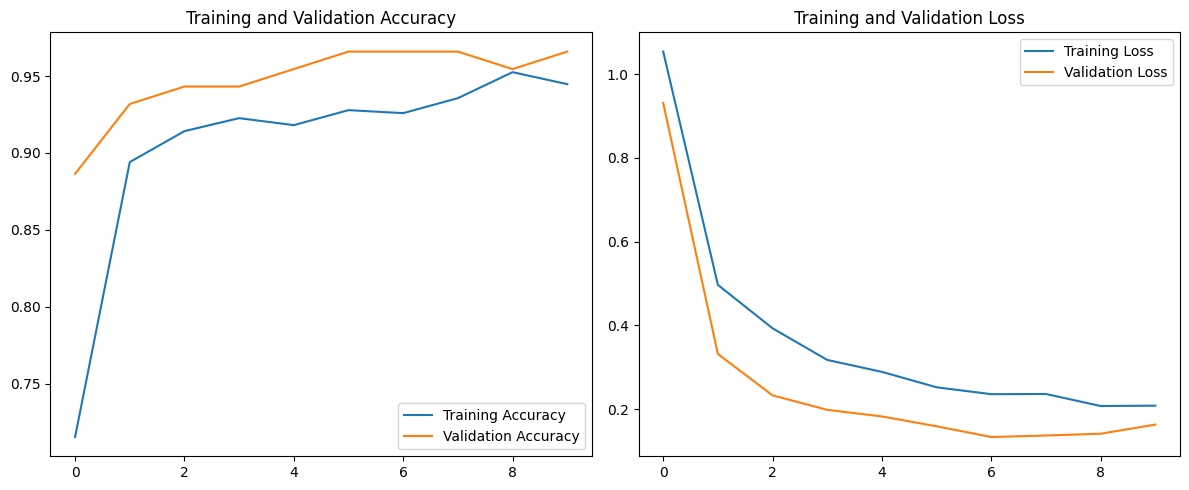

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_dir = "/content/classification-dataset"
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 10
PATIENCE = 3 # For Early Stopping



# Normalization values for ImageNet (which the models were trained on)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Data augmentation for training, just resize/crop for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        normalize
    ]),
}

# Load data using ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir, data_transforms['valid'])
}

# Create DataLoaders
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    for x in ['train', 'valid']
}

class_names = image_datasets['train'].classes
NUM_CLASSES = len(class_names)
print(f"Found {NUM_CLASSES} classes: {class_names}")


# This prevents the model collapse you saw before
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.stop = False

    def __call__(self, val_loss):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

# Train the Model
# We make this a function since we'll run it twice (once for feature extraction, once for fine-tuning)
def train_model(model, criterion, optimizer, scheduler, start_epoch, num_epochs, early_stopper):
    global history # Store history globally

    for epoch in range(start_epoch, start_epoch + num_epochs):
        print(f'\nEpoch {epoch}/{start_epoch + num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store history
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            # Check early stopping (only on validation phase)
            if phase == 'valid':
                scheduler.step() # PyTorch schedulers are often stepped per epoch
                early_stopper(epoch_loss)

        if early_stopper.stop:
            print("Early stopping triggered!")
            return model, epoch # Return the last completed epoch number

    return model, start_epoch + num_epochs - 1


# Phase 1: Feature Extraction
print("\n--- Phase 1: Training the Classifier Head ---")

# Load pre-trained ResNet50
model_ft = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# To use MobileNetV2 instead, uncomment these lines:
# model_ft = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V2)
# num_ftrs = model_ft.classifier[1].in_features
# model_ft.classifier[1] = nn.Linear(num_ftrs, NUM_CLASSES)

# Freeze all layers
for param in model_ft.parameters():
    param.requires_grad = False

# Replace the final layer
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
# Only optimize the new classifier head
optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=0.001)
# Learning rate scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Initialize history and early stopper
history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
early_stopper = EarlyStopping(patience=PATIENCE)

# Run training
model_ft, last_epoch = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, 0, INITIAL_EPOCHS, early_stopper)


# Phase 2: Fine-Tuning
if not early_stopper.stop: # Only fine-tune if we didn't stop early
    print("\n--- Phase 2: Fine-Tuning the Full Model ---")

    # Unfreeze all layers
    for param in model_ft.parameters():
        param.requires_grad = True

    # We MUST use a much smaller learning rate to avoid model collapse
    optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-5)
    exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    # Reset the early stopper
    early_stopper = EarlyStopping(patience=PATIENCE)

    # Continue training
    model_ft, _ = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, last_epoch + 1, FINE_TUNE_EPOCHS, early_stopper)


print("\n--- Training Complete ---")

# Plot Training History
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['valid_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['valid_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

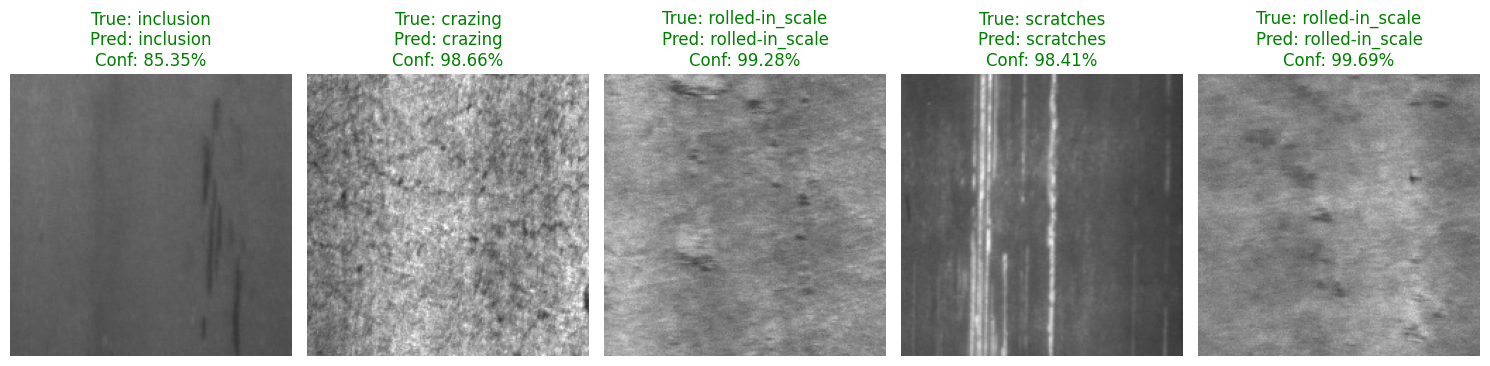

In [9]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
import numpy as np


data_dir = "/content/classification-dataset"
valid_dir = os.path.join(data_dir, "valid")


model_ft.eval()


test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


num_test_images = 5
test_image_paths = []
test_image_labels = []

class_folders = [os.path.join(valid_dir, c) for c in class_names if os.path.isdir(os.path.join(valid_dir, c))]

for _ in range(num_test_images):
    # Pick a random class folder
    random_class_folder = random.choice(class_folders)
    true_label = os.path.basename(random_class_folder)

    # Pick a random image from that folder
    random_image_name = random.choice(os.listdir(random_class_folder))
    image_path = os.path.join(random_class_folder, random_image_name)

    test_image_paths.append(image_path)
    test_image_labels.append(true_label)


plt.figure(figsize=(15, 8))

for i in range(num_test_images):
    true_label = test_image_labels[i]
    image_path = test_image_paths[i]

    # Load the image using PIL
    # We open the raw image, which is what matplotlib will show
    raw_image = Image.open(image_path).convert("RGB")

    # Apply the transformations to create the input tensor
    input_tensor = test_transform(raw_image)

    # Add a batch dimension (PyTorch models expect [Batch, Channel, Height, Width])
    # .unsqueeze(0) adds the batch dimension at the beginning
    input_batch = input_tensor.unsqueeze(0).to(device)

    # Get predictions
    with torch.no_grad(): # Disable gradient calculation for inference
        output = model_ft(input_batch)
        # Apply softmax to get probabilities
        probabilities = torch.nn.functional.softmax(output[0], dim=0)

        # Get the top score and predicted class index
        top_prob, top_class_index = torch.max(probabilities, 0)

    predicted_label = class_names[top_class_index.item()]
    confidence = top_prob.item()


    ax = plt.subplot(1, num_test_images, i + 1)

    # Matplotlib needs the image as a numpy array, not a tensor
    plt.imshow(raw_image)

    # Set title color
    if predicted_label == true_label:
        color = "green"
    else:
        color = "red"

    plt.title(
        f"True: {true_label}\n"
        f"Pred: {predicted_label}\n"
        f"Conf: {confidence:.2%}",
        color=color
    )
    plt.axis("off")

plt.tight_layout()
plt.show()